In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
import swifter
import nltk
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Embedding, Conv2D, MaxPooling2D, Dropout,Reshape, Flatten,LSTM
from tensorflow.keras import regularizers
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import classification_report


In [2]:
NUM_WORKERS = 8
TEST_SIZE = 0.3
LABEL_COLUMN_NAME = "oh_label"
TEXT_COLUMN_NAME = "Text"
DATASET_PATH = "../Data/ver1.csv"

## CNN with Word2vec

In [3]:
df= pd.read_csv(DATASET_PATH, index_col=False)
df = df.dropna()
df.drop(["Unnamed: 0", "index"],axis=1, inplace = True)

In [4]:
X,y = df[TEXT_COLUMN_NAME],df[LABEL_COLUMN_NAME]

In [36]:
stopwords = nltk.corpus.stopwords.words('english')
X = X.swifter.apply(lambda text: ' '.join([item for item in nltk.word_tokenize(text) if item not in stopwords]))
X = X.str.replace('[^\w\s]','')

In [38]:
from collections import Counter
results = Counter()
X.str.lower().str.split().apply(results.update)

In [63]:
counts = pd.DataFrame.from_dict(results, orient='index').reset_index()
counts.columns = ["index","count"]
counts

,index,count
0,im,12340
1,12,535
2,understand,2775
3,perfectly,394
4,you,34385
...,...,...
159691,sdre,1
159692,weezer,1
159693,mid90s,1
159694,greenwaldquote,1


In [67]:
counts = counts.sort_values("count",ascending=False).reset_index(drop=True)
counts[20000:]['count'].value_counts()

1    81681
2    28388
3    10856
4     6604
5     3963
6     3097
7     2186
8     1840
9     1081
Name: count, dtype: int64

In [73]:
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=93)

In [74]:
tokenizer = Tokenizer(filters='',lower=True,char_level=)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index

In [76]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
not_found = set()
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        not_found.add(word)
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

In [9]:
X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test,maxlen=X_train.shape[1])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [23]:
sequence_length = X_train.shape[1]
model = Sequential()
model.add(Embedding(vocabulary_size,EMBEDDING_DIM,weights=[embedding_matrix],trainable=False,input_shape=(sequence_length,)))
model.add(Reshape((sequence_length,EMBEDDING_DIM,1)))
model.add(Conv2D(100, (3, EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l1_l2(0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling2D((sequence_length - 4, 1), strides=(1,1)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2829, 300)         6000000   
_________________________________________________________________
reshape_5 (Reshape)          (None, 2829, 300, 1)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2827, 1, 100)      90100     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 1, 100)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 300)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [11]:
weights q= 1 - pd.Series(y).value_counts()/y.size
weights = weights.to_dict()
weights

{0.0: 0.26771, 1.0: 0.73229}

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
time_stopping_callback = tfa.callbacks.TimeStopping(seconds=60*60*15, verbose=1) 
history = model.fit(X_train,y_train,batch_size=200,epochs=1000,
                    validation_split=0.1,class_weight=weights,
                    use_multiprocessing=True,workers=8,callbacks=[callback,time_stopping_callback])

Epoch 1/1000
360/360 [==============================] - 946s 3s/step - loss: 0.1672 - accuracy: 0.8530 - recall_2: 0.8530 - precision_2: 0.8530 - val_loss: 0.3267 - val_accuracy: 0.8885 - val_recall_2: 0.8885 - val_precision_2: 0.8885
Epoch 2/1000
360/360 [==============================] - 953s 3s/step - loss: 0.1345 - accuracy: 0.8906 - recall_2: 0.8906 - precision_2: 0.8906 - val_loss: 0.2812 - val_accuracy: 0.9018 - val_recall_2: 0.9018 - val_precision_2: 0.9018
Epoch 3/1000
360/360 [==============================] - 954s 3s/step - loss: 0.1203 - accuracy: 0.9037 - recall_2: 0.9037 - precision_2: 0.9037 - val_loss: 0.2917 - val_accuracy: 0.8994 - val_recall_2: 0.8994 - val_precision_2: 0.8994
Epoch 4/1000
360/360 [==============================] - 957s 3s/step - loss: 0.1090 - accuracy: 0.9168 - recall_2: 0.9168 - precision_2: 0.9168 - val_loss: 0.2875 - val_accuracy: 0.8991 - val_recall_2: 0.8991 - val_precision_2: 0.8991
Epoch 5/1000
360/360 [==============================] - 956s

In [32]:
model.save("cnn_word2vec_second_chance")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train Metrics')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()
y_pred_test = model.predict(X_test)
print("Test: \n")
print(classification_report(y_test.argmax(axis=1),y_pred_test.argmax(axis=1)))
print("\nTrain: \n")
y_pred_train = model.predict(X_train)
print(classification_report(y_train.argmax(axis=1),y_pred_train.argmax(axis=1)))

In [77]:
count,len(count)

(89778,
 {'nichalp',
  'serendeva',
  'cmnf',
  'ayou',
  'tletplatinum',
  'deep_throats',
  'virtualy',
  'williamsonincredible',
  'wprbi',
  'bookchin',
  'thefinebros',
  'currs',
  'aymannathem',
  'explataions',
  'crossdominance',
  'lupton',
  '3306',
  'dean_machine_',
  'richardmeal',
  'theodulf',
  'nowtabloid',
  'selfaggrandize',
  'kalindaruk',
  'importanceoman',
  '25th',
  'yuber',
  'doylestownnan',
  'judithchiche',
  'vaginabot',
  'cdps',
  'maņdana',
  'noticeboardincidentsip',
  'nyc88',
  'httptco1je0s98wmh',
  'mlps',
  'donnt',
  '38740843',
  'duru',
  'modbury',
  'talkteena',
  'kerrys',
  'ketabtoon',
  '6915513227',
  'wikilinks',
  'subsidiesi',
  'asselineau',
  'httptconwjzljbhoe',
  'carpocrations',
  'ellis_holt1',
  'happenedi',
  'httpwwwshilohregistrycomruleshtml',
  'etcthe',
  'breckinridge',
  'mcporpington',
  'rhus',
  'httpwwwmakdenesorgcontentarticle1956873html',
  'markhams',
  'sulaiman',
  'littlehoneyde',
  'cardiorespirtory',
  'with

## LSTM With Char Embedding

In [6]:
df= pd.read_csv(DATASET_PATH, index_col=False)
df = df.dropna()
df.drop(["Unnamed: 0", "index"],axis=1, inplace = True)

In [14]:
import re
df= pd.read_csv(DATASET_PATH, index_col=False)
df = df.dropna()
df.drop(["Unnamed: 0", "index"],axis=1, inplace = True)
regex = re.compile('[^a-z ]')
df[TEXT_COLUMN_NAME] = df[TEXT_COLUMN_NAME].swifter.apply(lambda text: regex.sub('',text.lower()))
lens = df[TEXT_COLUMN_NAME].swifter.apply(len)
df = df[(lens < lens.quantile(.75)) & (lens > 5)]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [16]:
X,y = df[TEXT_COLUMN_NAME],df[LABEL_COLUMN_NAME]
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=93)

In [17]:
toknizer = Tokenizer(char_level=True, oov_token='@',num_words=None)
toknizer.fit_on_texts(X_train)
X_train = toknizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,padding='post')

In [18]:
X_train.shape

(59949, 349)

In [19]:
model = Sequential()
model.add(LSTM(50,input_shape=(349,1),recurrent_dropout=0.2))
model.add(Dense(25, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


In [20]:
weights = 1 - y.value_counts()/y.size
weights = weights.to_dict()
weights

{0.0: 0.3027076077238213, 1.0: 0.6972923922761787}

In [21]:
X_train = np.expand_dims(X_train,axis=-1)

In [22]:
X_train.shape,y_train.shape

((59949, 349, 1), (59949,))

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
time_stopping_callback = tfa.callbacks.TimeStopping(seconds=60*60*8, verbose=1)
history = model.fit(X_train,y_train,batch_size=200,epochs=1000,
                    validation_split=0.05,class_weight=weights,
                    use_multiprocessing=True,workers=8,callbacks=[callback,time_stopping_callback])

Epoch 1/1000
285/285 [==============================] - 110s 381ms/step - loss: 0.2910 - accuracy: 0.4315 - val_loss: 0.6885 - val_accuracy: 0.3976
Epoch 2/1000
285/285 [==============================] - 136s 478ms/step - loss: 0.2877 - accuracy: 0.4912 - val_loss: 0.6823 - val_accuracy: 0.4857
Epoch 3/1000
285/285 [==============================] - 140s 491ms/step - loss: 0.2873 - accuracy: 0.4977 - val_loss: 0.6835 - val_accuracy: 0.4793
Epoch 4/1000
285/285 [==============================] - 145s 509ms/step - loss: 0.2871 - accuracy: 0.4979 - val_loss: 0.6882 - val_accuracy: 0.4793
Epoch 5/1000
285/285 [==============================] - 146s 511ms/step - loss: 0.2865 - accuracy: 0.4889 - val_loss: 0.6435 - val_accuracy: 0.6124
Epoch 6/1000
285/285 [==============================] - 145s 510ms/step - loss: 0.2764 - accuracy: 0.6073 - val_loss: 0.6512 - val_accuracy: 0.6237
Epoch 7/1000
285/285 [==============================] - 144s 505ms/step - loss: 0.2806 - accuracy: 0.5758 - val_

In [24]:
X_test = np.expand_dims(X_test,axis=-1)

In [39]:
model.save("lstm_second_chance")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train Metrics')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy','loss','val_loss'])
plt.show()
y_pred_test = model.predict(X_test)
y_pred_test[y_pred_test < 0.5] = 0
y_pred_test[y_pred_test >= 0.5] = 1
print("Test: \n")
print(classification_report(y_test.argmax(axis=1),y_pred_test))
print("\nTrain: \n")
y_pred_train = model.predict(X_train)
y_pred_train[y_pred_train < 0.5] = 0
y_pred_train[y_pred_train >= 0.5] = 1
print(classification_report(y_train.argmax(axis=1),y_pred_train))

In [33]:
model = Sequential()
model.add(LSTM(250,input_shape=(349,1),recurrent_dropout=0.2))
model.add(Dense(150, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(25, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 250)               252000    
_________________________________________________________________
dense_8 (Dense)              (None, 150)               37650     
_________________________________________________________________
dense_9 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_10 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 26        
Total params: 298,501
Trainable params: 298,501
Non-trainable params: 0
_________________________________________________________________


In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
time_stopping_callback = tfa.callbacks.TimeStopping(seconds=60*60*8, verbose=1)
history = model.fit(X_train,y_train,batch_size=200,epochs=1000,
                    validation_split=0.05,class_weight=weights,
                    use_multiprocessing=True,workers=8,callbacks=[callback,time_stopping_callback])

Epoch 1/1000
285/285 [==============================] - 2260s 8s/step - loss: 0.2926 - accuracy: 0.4367 - val_loss: 0.7022 - val_accuracy: 0.3202
Epoch 2/1000
285/285 [==============================] - 2178s 8s/step - loss: 0.2915 - accuracy: 0.3807 - val_loss: 0.7009 - val_accuracy: 0.3519
Epoch 3/1000
285/285 [==============================] - 2287s 8s/step - loss: 0.2893 - accuracy: 0.4332 - val_loss: 0.6615 - val_accuracy: 0.5480
Epoch 4/1000
285/285 [==============================] - 2329s 8s/step - loss: 0.2882 - accuracy: 0.4712 - val_loss: 0.7166 - val_accuracy: 0.4009
Epoch 5/1000
285/285 [==============================] - 2327s 8s/step - loss: 0.2875 - accuracy: 0.4995 - val_loss: 0.6810 - val_accuracy: 0.4990
Epoch 6/1000
285/285 [==============================] - 2366s 8s/step - loss: 0.2871 - accuracy: 0.5058 - val_loss: 0.6859 - val_accuracy: 0.5033
Epoch 7/1000
285/285 [==============================] - 2386s 8s/step - loss: 0.2862 - accuracy: 0.5152 - val_loss: 0.6861 -

In [37]:
model.save("lstm_2")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train Metrics')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy','loss','val_loss'])
plt.show()
y_pred_test = model.predict(X_test)
y_pred_test[y_pred_test < 0.5] = 0
y_pred_test[y_pred_test >= 0.5] = 1
print("Test: \n")
print(classification_report(y_test.argmax(axis=1),y_pred_test)
print("\nTrain: \n")
y_pred_train = model.predict(X_train)
y_pred_train[y_pred_train < 0.5] = 0
y_pred_train[y_pred_train >= 0.5] = 1
print(classification_report(y_train.argmax(axis=1),y_pred_train)

## Simple LSTM

In [5]:
y = pd.Categorical(df[LABEL_COLUMN_NAME]).codes
X = df[TEXT_COLUMN_NAME]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

count    100000.000000
mean         74.415120
std         146.039735
min           0.000000
25%          18.000000
50%          34.000000
75%          76.000000
max        9851.000000
Name: Text, dtype: float64


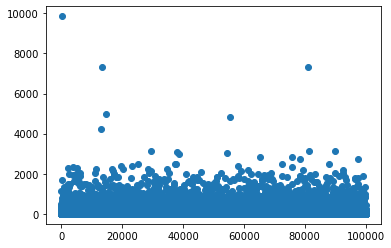

In [14]:
lens = X.swifter.apply(lambda text:len(nltk.word_tokenize(text)))
print(lens.describe())
plt.scatter(list(lens.index),lens.values)

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X.values,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((80000,), (20000,), (80000,), (20000,))

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
toknizer = Tokenizer(char_level=False, oov_token='@',num_words=100, split=' ',lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
toknizer.fit_on_texts(X_train)
seq = toknizer.texts_to_sequences(X_train)
seq = pad_sequences(seq,maxlen=77,padding='post')

In [21]:
X_train = seq

In [22]:
model = Sequential()
model.add(LSTM(70,input_shape=(100,1),recurrent_dropout=0.2))
model.add(Dense(60, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(4, activation="softmax"))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70)                20160     
_________________________________________________________________
dense (Dense)                (None, 60)                4260      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 44        
Total params: 26,604
Trainable params: 26,604
Non-trainable params: 0
_________________________________________________________________


In [25]:
weights = 1 - pd.Series(y).value_counts()/y.size
weights = weights.to_dict()
weights

{0: 0.26771, 1: 0.73229}

In [26]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
X_train = np.expand_dims(X_train,axis=-1)

In [29]:
import tensorflow_addons as tfa
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
time_stopping_callback = tfa.callbacks.TimeStopping(seconds=60*60*8, verbose=1) 
history = model.fit(X_train,y_train,batch_size=200,epochs=1000,
                    validation_split=0.1,class_weight=weights,
                    use_multiprocessing=True,workers=8,callbacks=[callback,time_stopping_callback])

Epoch 1/1000
360/360 [==============================] - 22s 61ms/step - loss: 0.2424 - accuracy: 0.6426 - val_loss: 0.6086 - val_accuracy: 0.6654
Epoch 2/1000
360/360 [==============================] - 23s 65ms/step - loss: 0.2421 - accuracy: 0.6483 - val_loss: 0.5908 - val_accuracy: 0.6910
Epoch 3/1000
360/360 [==============================] - 24s 65ms/step - loss: 0.2410 - accuracy: 0.6546 - val_loss: 0.5968 - val_accuracy: 0.6549
Epoch 4/1000
360/360 [==============================] - 24s 65ms/step - loss: 0.2406 - accuracy: 0.6516 - val_loss: 0.5713 - val_accuracy: 0.6951
Epoch 5/1000
360/360 [==============================] - 23s 64ms/step - loss: 0.2401 - accuracy: 0.6487 - val_loss: 0.6144 - val_accuracy: 0.6490
Epoch 6/1000
360/360 [==============================] - 23s 65ms/step - loss: 0.2399 - accuracy: 0.6532 - val_loss: 0.5998 - val_accuracy: 0.6597
Epoch 7/1000
360/360 [==============================] - 23s 64ms/step - loss: 0.2389 - accuracy: 0.6532 - val_loss: 0.6278 -

Epoch 57/1000
360/360 [==============================] - 23s 65ms/step - loss: 0.2255 - accuracy: 0.6889 - val_loss: 0.5813 - val_accuracy: 0.6861
Epoch 58/1000
360/360 [==============================] - 23s 65ms/step - loss: 0.2256 - accuracy: 0.6830 - val_loss: 0.5654 - val_accuracy: 0.6982
Epoch 59/1000
360/360 [==============================] - 24s 66ms/step - loss: 0.2252 - accuracy: 0.6888 - val_loss: 0.5980 - val_accuracy: 0.6761
Epoch 60/1000
360/360 [==============================] - 23s 65ms/step - loss: 0.2258 - accuracy: 0.6872 - val_loss: 0.5853 - val_accuracy: 0.6729
Epoch 61/1000
360/360 [==============================] - 23s 65ms/step - loss: 0.2251 - accuracy: 0.6865 - val_loss: 0.5639 - val_accuracy: 0.6955
Epoch 62/1000
360/360 [==============================] - 23s 65ms/step - loss: 0.2252 - accuracy: 0.6896 - val_loss: 0.5730 - val_accuracy: 0.7011
Epoch 63/1000
360/360 [==============================] - 23s 64ms/step - loss: 0.2250 - accuracy: 0.6907 - val_loss: 0

In [ ]:
model.save("lstm_simple_embedding")

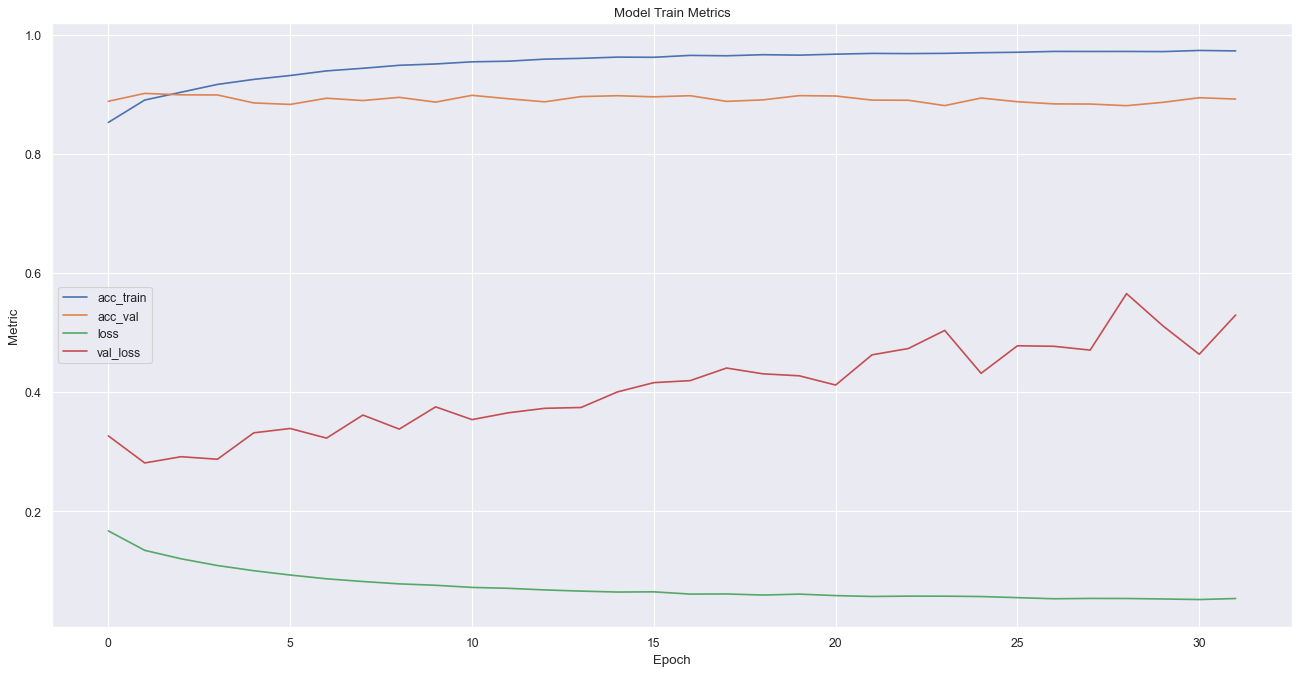

In [110]:
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(20,10), dpi=80)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train Metrics')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend(['acc_train', "acc_val",'loss',"val_loss"])
plt.show()

In [ ]:
X_test = np.expand_dims(X_test,axis=-1)

In [ ]:
from sklearn.metrics import classification_report
y_pred_test = model.predict(X_test)
print(classification_report(y_test,y_pred_test.argmax(axis=1)))

In [ ]:
from sklearn.metrics import classification_report
y_pred_train = model.predict(X_train)
print(classification_report(y_train,y_pred_train.argmax(axis=1)))